<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Finetuning-Pre-trained-BERT-Model-on-Text-Classification-Task-And-Inferencing-with-ONNX-Runtime" data-toc-modified-id="Finetuning-Pre-trained-BERT-Model-on-Text-Classification-Task-And-Inferencing-with-ONNX-Runtime-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Finetuning Pre-trained BERT Model on Text Classification Task And Inferencing with ONNX Runtime</a></span><ul class="toc-item"><li><span><a href="#Tokenizer" data-toc-modified-id="Tokenizer-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Tokenizer</a></span></li><li><span><a href="#Model-FineTuning" data-toc-modified-id="Model-FineTuning-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Model FineTuning</a></span></li><li><span><a href="#Onnx-Runtime" data-toc-modified-id="Onnx-Runtime-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Onnx Runtime</a></span></li></ul></li><li><span><a href="#Reference" data-toc-modified-id="Reference-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Reference</a></span></li></ul></div>

In [1]:
# code for loading the format for the notebook
import os

# path : store the current path to convert back to it later
path = os.getcwd()
os.chdir(os.path.join('..', '..', 'notebook_format'))

from formats import load_style
load_style(css_style='custom2.css', plot_style=False)

In [2]:
os.chdir(path)

# 1. magic for inline plot
# 2. magic to print version
# 3. magic so that the notebook will reload external python modules
# 4. magic to enable retina (high resolution) plots
# https://gist.github.com/minrk/3301035
%matplotlib inline
%load_ext watermark
%load_ext autoreload
%autoreload 2

import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%watermark -a 'Ethen' -d -t -v -p datasets,transformers,torch,tokenizers,numpy,pandas,matplotlib,onnxruntime

Author: Ethen

Python implementation: CPython
Python version       : 3.7.3
IPython version      : 7.16.1

datasets    : 1.6.2
transformers: 4.5.0
torch       : 1.7.0+cu101
tokenizers  : 0.10.2
numpy       : 1.20.3
pandas      : 1.2.4
matplotlib  : 3.4.2
onnxruntime : 1.8.0



# Finetuning Pre-trained BERT Model on Text Classification Task And Inferencing with ONNX Runtime

In this article, we'll be going over two main things:

- Process of finetuning a pre-trained BERT model towards a text classification task, more specificially, the [Quora Question Pairs](https://www.kaggle.com/c/quora-question-pairs/data) challenge.
- Process of converting our model into [ONNX](https://onnx.ai/) format, and perform inferencing benchmark with [ONNX runtime](https://www.onnxruntime.ai/).

In [3]:
from datasets import load_dataset, DatasetDict, Dataset

dataset_dict = load_dataset("quora")
dataset_dict

Using custom data configuration default
Reusing dataset quora (/home/mingyuliu/.cache/huggingface/datasets/quora/default/0.0.0/36ba4cd42107f051a158016f1bea6ae3f4685c5df843529108a54e42d86c1e04)


DatasetDict({
    train: Dataset({
        features: ['questions', 'is_duplicate'],
        num_rows: 404290
    })
})

In [4]:
dataset_dict['train'][0]

{'is_duplicate': False,
 'questions': {'id': [1, 2],
  'text': ['What is the step by step guide to invest in share market in india?',
   'What is the step by step guide to invest in share market?']}}

In [5]:
test_size = 0.1
val_size = 0.1
dataset_dict_test = dataset_dict['train'].train_test_split(test_size=test_size)
dataset_dict_train_val = dataset_dict_test['train'].train_test_split(test_size=val_size)

dataset_dict = DatasetDict({
    "train": dataset_dict_train_val["train"],
    "val": dataset_dict_train_val["test"],
    "test": dataset_dict_test["test"]
})
dataset_dict

DatasetDict({
    train: Dataset({
        features: ['questions', 'is_duplicate'],
        num_rows: 327474
    })
    val: Dataset({
        features: ['questions', 'is_duplicate'],
        num_rows: 36387
    })
    test: Dataset({
        features: ['questions', 'is_duplicate'],
        num_rows: 40429
    })
})

## Tokenizer

We won't be going over the details of the pre-trained tokenizer or model.

In [6]:
from transformers import AutoTokenizer

pretrained_model_name_or_path = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path)
tokenizer

PreTrainedTokenizerFast(name_or_path='distilbert-base-uncased', vocab_size=30522, model_max_len=512, is_fast=True, padding_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})

We can feed our tokenizer directly with a pair of sentences.

In [7]:
encoded_input = tokenizer(
    'What is the step by step guide to invest in share market in india?',
    'What is the step by step guide to invest in share market?'
)
encoded_input

{'input_ids': [101, 2054, 2003, 1996, 3357, 2011, 3357, 5009, 2000, 15697, 1999, 3745, 3006, 1999, 2634, 1029, 102, 2054, 2003, 1996, 3357, 2011, 3357, 5009, 2000, 15697, 1999, 3745, 3006, 1029, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

Decoding the tokenized inputs, this model's tokenizer adds some special tokens such as, `[SEP]`, that is used to indicate which token belongs to which segment/pair.

In [8]:
tokenizer.decode(encoded_input["input_ids"])

'[CLS] what is the step by step guide to invest in share market in india? [SEP] what is the step by step guide to invest in share market? [SEP]'

The proprocessing step will be task specific, if we happen to be using another dataset, this function needs to be modified accordingly.

In [9]:
def tokenize_fn(examples):
    labels = [int(label) for label in examples['is_duplicate']]
    texts = [question['text'] for question in examples['questions']]
    texts1 = [text[0] for text in texts]
    texts2 = [text[1] for text in texts]
    tokenized_examples = tokenizer(texts1, texts2)
    tokenized_examples['labels'] = labels
    return tokenized_examples

In [10]:
dataset_dict_tokenized = dataset_dict.map(
    tokenize_fn,
    batched=True,
    num_proc=8,
    remove_columns=['is_duplicate', 'questions']
)
dataset_dict_tokenized

DatasetDict({
    train: Dataset({
        features: ['attention_mask', 'input_ids', 'labels'],
        num_rows: 327474
    })
    val: Dataset({
        features: ['attention_mask', 'input_ids', 'labels'],
        num_rows: 36387
    })
    test: Dataset({
        features: ['attention_mask', 'input_ids', 'labels'],
        num_rows: 40429
    })
})

In [11]:
dataset_dict_tokenized['train'][0]

{'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 'input_ids': [101,
  2073,
  2064,
  1045,
  3422,
  8750,
  1029,
  102,
  2073,
  2064,
  1045,
  3422,
  2070,
  7284,
  13198,
  1029,
  102],
 'labels': 0}

## Model FineTuning

Having preprocessed our raw dataset, for our text classification task, we use `AutoModelForSequenceClassification` class to load the pre-trained model, the only other argument we need to specify is the number of class/label our text classification task has. Upon instantiating the model for the first time, we'll see some warnings generated, telling us we should fine tune this model on our down stream tasks before using it. 

In [12]:
model_checkpoint = 'text_classification'
num_labels = 2

In [13]:
from transformers import (
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding
)

# we'll save the model after fine tuning it once, so we can skip the fine tuning part during
# the second round if we detect that we already have one available
if os.path.isdir(model_checkpoint):
    model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint)
else:
    model = AutoModelForSequenceClassification.from_pretrained(pretrained_model_name_or_path, num_labels=num_labels)

print('# of parameters: ', model.num_parameters())
model

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classi

# of parameters:  66955010


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
       

In [14]:
data_collator = DataCollatorWithPadding(tokenizer, padding=True)
data_collator

DataCollatorWithPadding(tokenizer=PreTrainedTokenizerFast(name_or_path='distilbert-base-uncased', vocab_size=30522, model_max_len=512, is_fast=True, padding_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}), padding=True, max_length=None, pad_to_multiple_of=None)

We can perform all sorts of hyper parameter tuning on the fine tuning step, here we'll pick some default parameters for illustration purposes.

In [15]:
batch_size = 128
args = TrainingArguments(
    "quora",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=2,
    weight_decay=0.01,
    load_best_model_at_end=True
)

trainer = Trainer(
    model,
    args,
    data_collator=data_collator,
    train_dataset=dataset_dict_tokenized["train"],
    eval_dataset=dataset_dict_tokenized['val']
)

In [16]:
if not os.path.isdir(model_checkpoint):
    trainer.train()
    model.save_pretrained(model_checkpoint)

Epoch,Training Loss,Validation Loss,Runtime,Samples Per Second
1,0.295900,0.281624,25.984100,1400.357000
2,0.239800,0.267138,26.053700,1396.614000


The next couple of code chunks performs batch inferencing on our dataset, and reports standard binary classification evaluation metrics.

In [17]:
import torch
import torch.nn.functional as F

def predict(model, example, round_digits: int = 5):
    input_ids = example['input_ids'].to(model.device)
    attention_mask = example['attention_mask'].to(model.device)
    batch_labels = example['labels'].detach().cpu().numpy().tolist()
    model.eval()
    with torch.no_grad():
        batch_output = model(input_ids, attention_mask)

    batch_scores = F.softmax(batch_output.logits, dim=-1)[:, 1]
    batch_scores = np.round(batch_scores.detach().cpu().numpy(), round_digits).tolist()
    return batch_scores, batch_labels

In [18]:
from torch.utils.data import DataLoader

def predict_data_loader(model, data_loader: DataLoader) -> pd.DataFrame:
    scores = []
    labels = []
    for example in data_loader:
        batch_scores, batch_labels = predict(model, example)
        scores += batch_scores
        labels += batch_labels

    df_predictions = pd.DataFrame.from_dict({'scores': scores, 'labels': labels})
    return df_predictions

In [19]:
data_loader = DataLoader(dataset_dict_tokenized['test'], collate_fn=data_collator, batch_size=64)
start = time.time()
df_predictions = predict_data_loader(model, data_loader)
end = time.time()
print('elapsed: ', end - start)
print(df_predictions.shape)
df_predictions.head()

elapsed:  29.81020760536194
(40429, 2)


,scores,labels
0,0.96720,0
1,0.87566,1
2,0.00545,0
3,0.22137,1
4,0.00137,0


In [20]:
import sklearn.metrics as metrics

def compute_binary_classification_metrics(y_true, y_score, round_digits: int = 3):
    auc = metrics.roc_auc_score(y_true, y_score)
    log_loss = metrics.log_loss(y_true, y_score)

    precision, recall, threshold = metrics.precision_recall_curve(y_true, y_score)
    f1 = 2 * (precision * recall) / (precision + recall)

    mask = ~np.isnan(f1)
    f1 = f1[mask]
    precision = precision[mask]
    recall = recall[mask]

    best_index = np.argmax(f1)
    precision = precision[best_index]
    recall = recall[best_index]
    f1 = f1[best_index]
    return {
        'auc': round(auc, round_digits),
        'precision': round(precision, round_digits),
        'recall': round(recall, round_digits),
        'f1': round(f1, round_digits),
        'log_loss': round(log_loss, round_digits)
    }

In [21]:
compute_binary_classification_metrics(df_predictions['labels'], df_predictions['scores'])

{'auc': 0.955,
 'precision': 0.807,
 'recall': 0.902,
 'f1': 0.852,
 'log_loss': 0.263}

## Onnx Runtime

This section walks through the process of serializing our Pytorch model into [ONNX](https://onnx.ai/) format, and using [ONNX runtime](https://www.onnxruntime.ai/) for inferencing.

Exporting the model can be done via the `torch.onnx.export` function, which requires a sample input.

In [22]:
data_loader = DataLoader(dataset_dict_tokenized['test'], collate_fn=data_collator, batch_size=8)
example = next(iter(data_loader))

model = model.to('cuda')
input_ids = example['input_ids'].to(model.device)

example['input_ids'][:2]

tensor([[ 101, 3183, 2079, 2017, 2293, 1996, 2087, 1998, 2339, 1029,  102, 3183,
         2079, 2017, 2293, 2087, 1998, 2339, 1029,  102,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0],
        [ 101, 2129, 2116, 9646, 2515, 1996, 5304, 2428, 2031, 1029,  102, 2129,
         2116, 9646, 2024, 2045, 1029,  102,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0]])

For our neural network computational graph, we expect a single input with a dynamic batch size and sequence length, as well as a single output, which a dynamic batch size. We need to specify `dynamic_axes`, so during inferencing, onnx won't be limited to the sample input size we've provided when exporting the model into onnx format.

In [23]:
opset_version = 12
onnx_model_path = 'text_classification.onnx'

torch.onnx.export(
    model,
    input_ids,
    onnx_model_path,
    opset_version=opset_version,
    input_names=['input_ids'],
    output_names=['output'],
    dynamic_axes={
        'input_ids': {0: 'batch_size', 1: 'sequence_len'},
        'output': {0: 'batch_size'},
    }
)

/home/mingyuliu/.local/lib/python3.7/site-packages/transformers/modeling_utils.py:1790: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  input_tensor.shape[chunk_dim] == tensor_shape for input_tensor in input_tensors


We'll also experiment dynamic quantization on our onnx model. Quantization here perfers to converting our weights or activations in our models from a floating point representation to an integer reresentation. Based on the documentation, this is the simplest form of applying quantization, where our weights are quantized ahead of time but the activations are dynamically quantized during inference time.

Given an already trained model, quantization provides a quick way for us to make a tradeoff between model performance versus model size and latency without the need of re-training our models with different parameter settings.

In [24]:
from onnxruntime.quantization import quantize_dynamic, QuantType

quantized_onnx_model_path = 'quantized_text_classification.onnx'
quantize_dynamic(
    onnx_model_path,
    quantized_onnx_model_path,
    activation_type=QuantType.QUInt8,
    weight_type=QuantType.QUInt8
)
print('ONNX full precision model size (MB):', os.path.getsize(onnx_model_path) / (1024 * 1024))
print('ONNX quantized model size (MB):', os.path.getsize(quantized_onnx_model_path) / (1024 * 1024))

ONNX full precision model size (MB): 255.44387531280518
ONNX quantized model size (MB): 64.08816242218018


One of the most important parameters to tune when using onnxruntime is `intra_op_num_threads`.

In [25]:
from onnxruntime import InferenceSession, SessionOptions


def create_inference_session(
    model_path: str,
    intra_op_num_threads: int = 24,
    provider: str = 'CPUExecutionProvider'
) -> InferenceSession: 

    options = SessionOptions()
    options.intra_op_num_threads = intra_op_num_threads

    # load the model as a onnx graph
    session = InferenceSession(model_path, options, providers=[provider])
    session.disable_fallback()
    return session

We test the inferencing API by feeding the original PyTorch model and ONNX model with a sample input.

In [26]:
model = model.to('cuda')

# sample data
input_ids = dataset_dict_tokenized['test']['input_ids'][:1]

# gpu inferencing
model.eval()
with torch.no_grad():
    torch_input_ids = torch.LongTensor(input_ids).to(model.device)
    torch_output = model(torch_input_ids).logits.detach().cpu().numpy()

# onnx runtime inferencing
input_feed = {'input_ids': input_ids}

session = create_inference_session(onnx_model_path)
onnx_output = session.run(['output'], input_feed)[0]

quantized_session = create_inference_session(quantized_onnx_model_path)
quantized_onnx_output = quantized_session.run(['output'], input_feed)[0]

if np.allclose(torch_output, onnx_output, atol=1e-5):
    print("Exported model has been tested with ONNXRuntime, and the result looks good!")

print('input_ids: ', input_ids)
print('onnx output: ', onnx_output)
print('quantized onnx output: ', quantized_onnx_output)

Exported model has been tested with ONNXRuntime, and the result looks good!
input_ids:  [[101, 3183, 2079, 2017, 2293, 1996, 2087, 1998, 2339, 1029, 102, 3183, 2079, 2017, 2293, 2087, 1998, 2339, 1029, 102]]
onnx output:  [[-1.7153382  1.6686633]]
quantized onnx output:  [[-1.7923875  1.6911284]]


The next few section runs the benchmark on different batch sizes and inferencing options.

In [27]:
from contextlib import contextmanager

@contextmanager
def track_infer_time(buffer):
    start = time.time()
    yield
    end = time.time()
    elasped_ms = (end - start) * 1000
    buffer.append(elasped_ms)

In [28]:
from tqdm import trange

def benchmark_pytorch(model, input_ids, n_rounds: int, n_warmup_rounds: int = 0):
    for _ in range(n_warmup_rounds):
        model(input_ids)

    time_buffer = []
    for _ in trange(n_rounds, desc="Benchmarking"):
        with track_infer_time(time_buffer):
            model(input_ids).logits.detach().cpu().numpy()
 
    return time_buffer


def benchmark_onnx(session, input_ids, n_rounds: int, n_warmup_rounds: int = 0):
    """Expects the input_ids to be padded to the same sequence length, e.g. coming from DataLoader"""
    time.sleep(10)
    input_feed = {'input_ids': input_ids.detach().cpu().numpy()}

    for _ in range(n_warmup_rounds):
        session.run(['output'], input_feed)[0]

    time_buffer = []
    for _ in trange(n_rounds, desc="Benchmarking"):
        with track_infer_time(time_buffer):
            onnx_output = session.run(['output'], input_feed)[0]
 
    return time_buffer


def benchmark_dynamic_onnx(session, input_ids, n_rounds: int, n_warmup_rounds: int = 0):
    """
    Expects the input ids to be of dynamic size (i.e. non-padded), e.g. coming from a slice
    of dataset.
    """
    time.sleep(10)
    input_feed = {'input_ids': [input_ids[0]]}
    for _ in range(n_warmup_rounds):
        session.run(['output'], input_feed)[0]

    time_buffer = []
    for _ in trange(n_rounds, desc="Benchmarking"):
        with track_infer_time(time_buffer):
            batch_onnx_output = []
            for input_id in input_ids:
                input_feed = {'input_ids': [input_id]}
                onnx_output = session.run(['output'], input_feed)[0]
                batch_onnx_output.append(onnx_output)

            outputs = np.concatenate(batch_onnx_output)

    return time_buffer

In [29]:
n_rounds = 50
batch_sizes = [1, 4, 8, 16, 32, 64]
model_options = [
    'pytorch_gpu',  # pytorch cpu was really slow, not including it in the benchmark
    'onnx_cpu',
    'dynamic_onnx_cpu',
    'quantized_dynamic_onnx_cpu'
]

batch_time_results = {}
for batch_size in batch_sizes:

    results = {}
    for model_option in model_options:
        if model_option == 'pytorch_gpu':
            model = model.to('cuda')
            model = model.half()

            data_loader = DataLoader(
                dataset_dict_tokenized['test'],
                collate_fn=data_collator,
                batch_size=batch_size
            )
            example = next(iter(data_loader))
            input_ids = example['input_ids'].to(model.device)

            time_buffer = benchmark_pytorch(model, input_ids, n_rounds)
        elif model_option == 'onnx_cpu':
            data_loader = DataLoader(
                dataset_dict_tokenized['test'],
                collate_fn=data_collator,
                batch_size=batch_size
            )
            example = next(iter(data_loader))
            input_ids = example['input_ids'].to('cpu')

            time_buffer = benchmark_onnx(session, input_ids, n_rounds)
        elif model_option == 'dynamic_onnx_cpu':
            input_ids = dataset_dict_tokenized['test'][:batch_size]['input_ids']
            time_buffer = benchmark_dynamic_onnx(session, input_ids, n_rounds)
        elif model_option == 'quantized_dynamic_onnx_cpu':
            input_ids = dataset_dict_tokenized['test'][:batch_size]['input_ids']
            time_buffer = benchmark_dynamic_onnx(quantized_session, input_ids, n_rounds)
        else:
            raise ValueError(f'unknown model option {model_option}')

        results[model_option] = time_buffer

    time_results = {k: np.mean(v) for k, v in results.items()}

    for model_option, timing in time_results.items():
        if model_option in batch_time_results:
            batch_time_results[model_option].append(timing)
        else:
            batch_time_results[model_option] = [timing]

pd.DataFrame(batch_time_results)

Benchmarking: 100%|██████████| 50/50 [00:19<00:00,  2.59it/s]


,pytorch_gpu,onnx_cpu,dynamic_onnx_cpu,quantized_dynamic_onnx_cpu
0,8.551154,9.596491,5.209341,5.088263
1,18.337703,24.058056,20.660338,23.547111
2,8.817515,87.345872,50.401716,39.264908
3,7.984161,122.232432,129.506488,96.240478
4,8.194990,381.194353,250.328255,160.316586
5,12.720132,968.035669,565.695109,385.194440


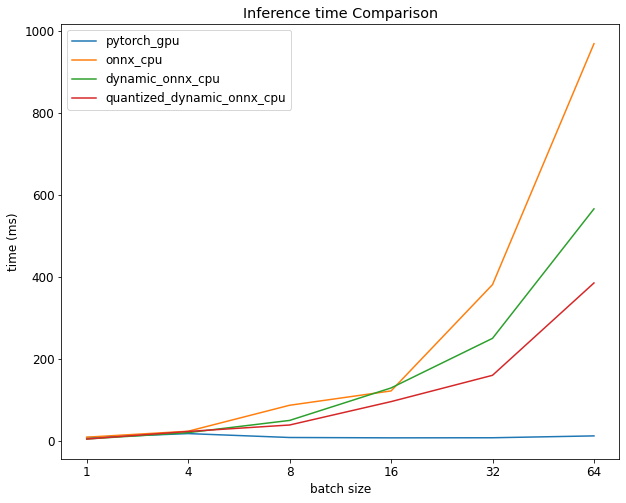

In [30]:
# change default style figure and font size
plt.rcParams['figure.figsize'] = 10, 8
plt.rcParams['font.size'] = 12

for model_name, time_list in batch_time_results.items():
    plt.plot(time_list, label=model_name)

plt.xticks(range(len(batch_sizes)), batch_sizes)
plt.xlabel('batch size')
plt.ylabel('time (ms)')
plt.title('Inference time Comparison')
plt.legend()
plt.show()

A couple of observations from the benchmark table and graph above.

- By converting our model to ONNX runtime, on small batch sizes, we can get similar CPU inference performances to PyTorch's GPU inferencing.
- It is a common practice in GPU settings to work with batched and padded data. i.e. Each batch of data are all padded to a fixed sequence length. Doing this degrades the perform for CPU inferencing, which has a lot less parallelism in place compared to GPU. Hence when conducting inferencing on a CPU, it's better to perform dynamic sequence length inferencing, with one example at a time.
- Not surprisingly, combining quantization and dynamic sequence length achieves the best inferencing performance in a CPU setting. Though still unable to match the performance of a GPU inferencing when the batch size increases.

We've only scratched the surface on what's possible in terms of speeding up our models for inferencing. The content in this article assumes we have a fix model to work with. If latency is an utmost concern for our deployment, we can always go back and perform better tuning on our models. There are various techniques for compressing large neural network models, we'll look at them in a separate post.

# Reference

- [Jupyter Notebook: Fine-tuning a model on a text classification task](https://nbviewer.jupyter.org/github/huggingface/notebooks/blob/master/examples/text_classification.ipynb)
- [Jupyter Notebook: Exporting transformers model to ONNX](https://nbviewer.jupyter.org/github/huggingface/transformers/blob/master/notebooks/04-onnx-export.ipynb)
- [Blog: Faster and smaller quantized NLP with Hugging Face and ONNX Runtime](https://medium.com/microsoftazure/faster-and-smaller-quantized-nlp-with-hugging-face-and-onnx-runtime-ec5525473bb7)
- [PyTorch Documentation: Dynamic Quantization](https://pytorch.org/tutorials/recipes/recipes/dynamic_quantization.html)